# 第十三週：LLM Information Extraction
本周課程為「LLM Information Extraction」，主要會使用到 Langchian 套件與 HuggingFace 模型來實作
1. LLM Inference 基本範例
2. Prompt Engineering
3. Information Extraction(Sentiment classification, NER)

### 大綱：
1. LLM inference 基本範例
    * Langchian 介紹
      * Chain
        * LCEL (LangChain Expression Language)
        * RunnableSequence
        * RunnableParallel
      * Prompt templete
        * PromptTemplate
        * ChatPromptTemplate
          * System prompt
          * User prompt
      * Output parser
    * Inference

2. Prompt engineering
    * Few-shot
    * CoT
    * Self-consistency

3. 資料集實作 Information Extraction (Tagging)
    * 句子情緒判別 Sentiment Classification (Positive, Neutral, Negative)
    * NER

4. Retrieve QA (RAG)
    * 學校選課規範

# 連接雲端資料夾

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 套件安裝

In [2]:
!pip install jieba

!pip install sentence-transformers
!pip install transformers
!pip install sentencepiece

# 用於 transformer 加速
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes

!pip install langchain-chroma
!pip install pypdf
!pip install langchain
!pip install huggingface_hub
!pip install grandalf
!pip install pandas
!pip install ctransformers
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
import os
from getpass import getpass

import pandas as pd
import ast
import json
import re
import jieba

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from transformers import BitsAndBytesConfig # huggingface 量化

from langchain_community.llms import HuggingFaceEndpoint

from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables import RunnableLambda

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

In [59]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 10

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

# 設定文字雲中文字體路徑 金萱粉圓體2.0
FontPath = '/content/drive/MyDrive/w12_13/jf-openhuninn-2.0.ttf' # 設定字型
# FontPath = './SourceHanSansTW-Regular.otf' # 設定字型

plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 150

# Path to the custom font
font_path = '/content/drive/MyDrive/w12_13/jf-openhuninn-2.0.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: jf-openhuninn-2.0


# HuggingFace Token

輸入 HuggingFace Token
- get a token: https://huggingface.co/docs/api-inference/quicktour#get-your-api-token

In [10]:
HUGGINGFACEHUB_API_TOKEN = getpass()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

··········


# 1. LLM inference 基本範例

## Langchian 介紹
- 專門用來開發語言模型(Language Model)相關應用的框架(framework)
- 讓開發者整合不同的語言模型，開發像 ChatGPT, 聊天機器人、數位助理等等應用程式

<img src="https://python.langchain.com/v0.1/svg/langchain_stack.svg" width="50%"><img src="https://wangwei1237.github.io/2023/09/20/Introduction-to-LangChain/langchain.png" width="50%">
- **LangChain Libraries LangChain**: 相關的功能與 API 等等，支援 Python 與 JavaScript
- **LangChain Templates**: 一些常見的 LangChain 模板(templates)，讓開發者可以套用，省去重新開發的成本
- **LangServe**: 可以將 LangChain 的 chain 開發成 REST API 的部件
- **LangSmith**: 讓開發者對語言模型進行測試、評估、除錯、監控等行為的 1 個平台


### 載入 LLM 模型 & 基本詢問
- LLM
  - 全參數模型
    - 一般模型在訓練時多使用 32-Bit 或 16-Bit 的浮點數
    - 7B 16-Bit 的模型，要消耗掉 13 GiB 以上的 GPU 記憶體，13B 可能要 2x GiB 以上
  - Quantization 模型
    - 參考：https://ithelp.ithome.com.tw/m/articles/10330372
    - 將模型轉換成 8-Bit 或 4-Bit 甚至更低，減少模型佔用的 GPU 記憶體
- Langchian 與 HuggingFace 整合的兩種取得模型方式
  1.  HuggingFacePipeline
    - Load 至本地（需要本地資源）
  2.  HuggingFaceEndpoint
    - Load 至 huggingface 共享基礎設施

#### HuggingFacePipeline
- Colab 免費版本：15GB GPU RAM
- 7B 全參數模型無法在免費版的 Colab 中使用（GPU RAM 需求不足），使用 quantization 後的 model

In [11]:
quant_config = BitsAndBytesConfig(load_in_4bit=True)

print(quant_config.is_quantizable())
print(quant_config.quantization_method())

True
fp4


In [12]:
model_id = "google/gemma-1.1-7b-it"

tokenizer = AutoTokenizer.from_pretrained(model_id, token=HUGGINGFACEHUB_API_TOKEN)
# device_map="auto" 使用 GPU 加速
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", quantization_config=quant_config, token=HUGGINGFACEHUB_API_TOKEN)
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=300)
llm = HuggingFacePipeline(pipeline=pipe)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(


#### HuggingFaceEndpoint
- Langchian 整合 huggingface severless api (https://huggingface.co/docs/api-inference/index)
- 可使用超過 100,000 部署在 Hugging Face Hub 上的模型
- Host 在 Hugging Face shared infrastructure 上，無需本地資源
  - Dynamically loaded on shared infrastructure



In [13]:
# repo_id: HuggingFace 上的模型名稱，本範例使用 gemma 7b instruct 版本
    # huggingface: https://huggingface.co/google/gemma-1.1-7b-it
# temperature: 模型回答的活潑程度，0~1 越大每次回答的多樣性越高

llm = HuggingFaceEndpoint(
    repo_id="google/gemma-1.1-7b-it", temperature=1.0,model_kwargs={'token':HUGGINGFACEHUB_API_TOKEN, 'use_cache':False}
)
llm.invoke("你好，我想買鋼筆,推薦哪個品牌")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from langchain-huggingface package and should be used instead. To use it run `pip install -U from langchain-huggingface` and import as `from from langchain_huggingface import llms import HuggingFaceEndpoint`.
  warn_deprecated(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


'和型號？\n\n以下是鋼筆的品牌和型號：\n\n* Sailor Professional Gear 21\n* Lamy Safari\n* Platinum Century\n* Cross Townsend\n* Pilot Metropolitan\n\n以下是我對鋼筆的期望：\n\n* 外觀簡約、整潔\n* 筆動平順，寫出字跡清晰\n* 有良好的筆芯持球性\n* 適合日常使用和上課\n\n根據你的期望，以下推薦：\n\n* **Sailor Professional Gear 21**：外觀簡約、筆動平順，筆芯持球性良好，適合日常使用和上課。\n* **Pilot Metropolitan**：外觀簡約、筆動平順，筆芯持球性良好，適合日常使用和上課。\n* **Platinum Century**：外觀簡約、筆動平順，筆芯持球性良好，適合日常使用和上課。\n\n這三款鋼筆都符合你的期望，但Sailor Professional Gear 21 的筆芯持球性更好，適合日常使用和上課。'

In [14]:
llm.invoke("我在減肥幫我決定我的午餐要有甚麼菜色？")

'\n\n**減肥午餐菜色建議：**\n\n* **富含纖維的蔬菜：**香草、青椒、洋蔥、番茄、葉菜等。\n* **高含蛋白質的食品：**魚肉片、雞肉胸肉片、蛋白等。\n* **低脂肪的油類：** olive油或亞麻油。\n\n**具體午餐菜色建議：**\n\n* 香草肉排配洋蔥沙丁\n* 青椒雞肉飯配番茄清湯\n* 魚肉片配香草洋蔥飯\n* 蛋白配葉菜配 olive油\n\n**注意事項：**\n\n* 選擇富含纖維的蔬菜，以增加飽足感並幫助消食。\n* 選擇高含蛋白質的食品，以幫助減少食欲並促進肌肉合成。\n* 選擇低脂肪的油類，以避免加權。'

### Chain
- LCEL (LangChain Expression Language)
    - 官網介紹：https://python.langchain.com/v0.1/docs/expression_language/why/
    - Langchain 說明：LCEL 可以讓我們更簡單的開發複雜的 chain 應用，可以支援：Streaming, Parallelism, logging。
    - 為了簡單化，LCEL 有兩的主要功能
        1. 統一的協定(Protocol)：所有的 LCEL object 都要遵照 Runnable interface，簡單來說都要包含以下方法，來讓多個 LCEL object 之間可以 chain(鏈結起來):
            1. invoke (支援單一輸入、單一輸出）
            2. batch (支援多個輸入、多個輸出）
            3. stream (支援有部分結果就輸出的模式)
            4. ainvoke (async 版本的 invoke)
            5. abatch (async 版本的 batch)
            6. astream (async 版本的 stream)
            
            - 詳細定義：
                1. https://api.python.langchain.com/en/stable/runnables/langchain_core.runnables.base.Runnable.html#langchain_core.runnables.base.Runnable
                2. https://python.langchain.com/v0.1/docs/expression_language/interface/
        2. 組合語言：讓 chain 的組合更容易
            - 提供不同元件組合的功能，使用 "|" 將不同元件串在一起，例如：prompt | llm
- Chain
    - 可重複執行
    - 可自由組合
    - 有兩種主要的型態
        1. RunnableSequence: 依序執行每個 Runnable
        2. RunnableParallel: 同時執行 Runnable

#### RunnableSequence
- 依序執行每個 Runnable
- 使用 "|" 連結

In [15]:
template = """你是一位專家，我現在在對廚師的廚藝做評論，請問以下句子的情緒為何（正向,中性,負向）: {question}"""

prompt = PromptTemplate.from_template(template)

prompt_output = prompt.invoke({"question": '你為什麼有辦法能把水煮焦？'})
prompt_output

StringPromptValue(text='你是一位專家，我現在在對廚師的廚藝做評論，請問以下句子的情緒為何（正向,中性,負向）: 你為什麼有辦法能把水煮焦？')

In [16]:
print(prompt_output)
llm_output = llm.invoke(prompt_output)
llm_output

text='你是一位專家，我現在在對廚師的廚藝做評論，請問以下句子的情緒為何（正向,中性,負向）: 你為什麼有辦法能把水煮焦？'


'\n\n這句子的情緒為負向。因為煮水並非容易的事，如果能把水煮焦，表示廚師的技術並非出色。'

In [17]:
# RunnablePassthrough: 可以不變的傳遞整個 input

template = """你是一位專家，我現在在對廚師的廚藝做評論，請幫以下句子的評分情緒分數（介於 -1.0~1.0，越高分代表越正向，反之越負向）: {question}"""

prompt = PromptTemplate.from_template(template)

sentiment_value_chain = (
    {"question": RunnablePassthrough()}
    | prompt
    | llm
)
sentiment_value_chain.invoke("你為什麼有辦法能把水煮焦。")

'\n\n評分：-0.5\n\n解釋：這句子的評分情緒分數為 -0.5，因為它帶有輕微的負面情緒，因為它指責廚師在煮水方面有能力不足。'

#### RunnableParallel

In [18]:
# 設定繁體中文詞庫
jieba.set_dictionary("/content/drive/MyDrive/w12_13/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("/content/drive/MyDrive/w12_13/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

# 讀取情緒字典
liwc_dict = pd.read_csv("/content/drive/MyDrive/w12_13/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})



In [19]:
# call lexicon base function
def lexicon_base_sentiment_value(value: dict) -> str:
    tokens = getToken(value['question'])
    df = pd.DataFrame(tokens, columns=['word'])
    liwc_df = pd.merge(df, liwc_dict, how="left")
    sentiment_count = pd.DataFrame(
        liwc_df.groupby(["sentiments"]).size()
    ).reset_index()
    result_dict = sentiment_count.set_index('sentiments')[0].to_dict()
    print(result_dict)
    s_value = (result_dict.get('positive') if result_dict.get('positive') != None else 0) - (result_dict.get('negative') if result_dict.get('negative') != None else 0)
    return s_value


lexicon_sentiment_value_chain = RunnableLambda(lexicon_base_sentiment_value)

parallel = {"runnable_1": lexicon_sentiment_value_chain, "runnable_2": sentiment_value_chain}

chain = RunnableLambda(lambda x: x) | parallel
answer = chain.invoke({'question':'這鴨肉有夠生，生到連實習醫生都能把牠救活。'})

print(answer)

Building prefix dict from /content/drive/MyDrive/w12_13/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/w12_13/dict.txt.big ...
Dumping model to file cache /tmp/jieba.uc76bf7d024595214c81ac1380f1d54b2.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.uc76bf7d024595214c81ac1380f1d54b2.cache
Loading model cost 2.010 seconds.
DEBUG:jieba:Loading model cost 2.010 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


{}
{'runnable_1': 0, 'runnable_2': '\n\n評分情緒分數：-0.8\n\n**評估：**這句子帶有負面情緒，因為它以生 duck 的程度來評量廚師的廚藝，並且暗示廚師的廚藝不足以治癒受傷的鴨肉。'}


In [20]:
chain = RunnableParallel(lexicon=lexicon_sentiment_value_chain, LLM=sentiment_value_chain)
chain.invoke({'question':'跟你的餐點比，我比較喜歡吃土'})

{'affect': 1, 'positive': 1}


{'lexicon': 1,
 'LLM': '。\n\n**評分情緒分數：-0.8**\n\n**評釋：**此句子的情緒分數為 -0.8，因為它表達了對餐點的厭惡和對土的偏好，這是一個負面情緒。'}

### Prompt templete
- 官網：https://python.langchain.com/v0.1/docs/modules/model_io/prompts/quick_start/
- Prompt templete 可以預先定義一個要輸入給 LLM 的文字模板
- Langchian 提供了建立 prompt templete 的工具
- 通常有兩種型態：
    1. PromptTemplate: string
    2. ChatPromptTemplate: list of chat messages （適用 chat model: A chat model is a language model that uses chat messages as inputs and returns chat messages as outputs (as opposed to using plain text).）

#### PromptTemplate: string

In [21]:
template = """Question: {question}

Answer: Let's think step by step."""

prompt_template = PromptTemplate.from_template(template)

# 可以透過 .input_schema.schema() 查看 templete 有哪一些變數需要輸入
print(prompt_template.input_schema.schema())

# format 可以將變數輸入進去後查看完整的 prompt 長相
prompt_template.format(question="Who won the FIFA World Cup in the year 1994? ")

{'title': 'PromptInput', 'type': 'object', 'properties': {'question': {'title': 'Question', 'type': 'string'}}}


"Question: Who won the FIFA World Cup in the year 1994? \n\nAnswer: Let's think step by step."

In [22]:
# PromptTemplate 也是 implement Runnable interface，所以一樣可以使用 invoke
prompt = prompt_template.invoke({"question": "Who won the FIFA World Cup in the year 1994? "})
print(prompt)
prompt.to_string()

text="Question: Who won the FIFA World Cup in the year 1994? \n\nAnswer: Let's think step by step."


"Question: Who won the FIFA World Cup in the year 1994? \n\nAnswer: Let's think step by step."

#### ChatPromptTemplate: list of chat messages
- 內容為 chat message，當中有 "role" 角色的概念，讓 LLM 了解內容是什麼角色說的
- system: 這個role負責的是類似系統設定的文字提示，例如跟 LLM 說他是一個工程師，接下來要請他用他的專業寫 code；或是跟 LLM 說他是一個厲害的數學家，要請他用他的專業解題。
- user: 使用者說的話，例如問 LLM 的問題。

In [27]:
chat_template = ChatPromptTemplate.from_messages(
    [
        ("system", "你非常會做菜. 你的名字可以叫做 {name}."),
        ("human", "你會做甚麼餐點?"),
        ("ai", "我會做很多有趣的菜!"),
        ("human", "{user_input}"),
    ]
)
print(chat_template.input_schema.schema())
messages = chat_template.format_messages(name="勞贖", user_input="你有多厲害?")
messages

{'title': 'PromptInput', 'type': 'object', 'properties': {'name': {'title': 'Name', 'type': 'string'}, 'user_input': {'title': 'User Input', 'type': 'string'}}}


[SystemMessage(content='你非常會做菜. 你的名字可以叫做 勞贖.'),
 HumanMessage(content='你會做甚麼餐點?'),
 AIMessage(content='我會做很多有趣的菜!'),
 HumanMessage(content='你有多厲害?')]

Tips: 因為 {} 在 prompt templete 中代表變數輸入的位置，如果在文字中有需要用到大括號，請使用 "{{" 及 "}}"

### Output Parser
- 官網：https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/
- Output Parser 目的是要讓 LLM 生成的內容符合特定格式，例如：JSON, list, YAML 等
- Tips: LLM 生成式模型無法 100% 照著想要輸出的格式走，在使用時也要考慮到模型的能力。

以 JSON 為例

In [29]:
# 使用 Pydantic 來宣告資料型態
# Define your desired data structure.
class Joke(BaseModel):
    setup: str = Field(description="說一個有趣的雙關語笑話")
    punchline: str = Field(description="解釋這個笑話好笑的地方")

parser = JsonOutputParser(pydantic_object=Joke)

# 透過 get_format_instructions() 可以看到如何告訴 LLM 生成我們想要的格式的一些指令
parser.get_format_instructions()


'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"setup": {"title": "Setup", "description": "\\u8aaa\\u4e00\\u500b\\u6709\\u8da3\\u7684\\u96d9\\u95dc\\u8a9e\\u7b11\\u8a71", "type": "string"}, "punchline": {"title": "Punchline", "description": "\\u89e3\\u91cb\\u9019\\u500b\\u7b11\\u8a71\\u597d\\u7b11\\u7684\\u5730\\u65b9", "type": "string"}}, "required": ["setup", "punchline"]}\n```'

In [30]:
# And a query intented to prompt a language model to populate the data structure.
joke_query = "Tell me a joke."

# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser(pydantic_object=Joke)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n\n{query}\n",
    # template="Answer the user query.\n{format_instructions}\nDon't output any other explanation\n{query}\n",
    input_variables=["query"],
    # 將 format_instructions 也輸入到 prompt templete 中
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | llm | parser

answer = chain.invoke({"query": joke_query})

In [31]:
print(answer)
print(answer["setup"])
print(answer["punchline"])

{'setup': 'A man walks into a library...', 'punchline': "And asks the librarian, 'Do you have any books about paranoia?'"}
A man walks into a library...
And asks the librarian, 'Do you have any books about paranoia?'


In [32]:
# 查看 chain 架構
chain.get_graph().print_ascii()

      +-------------+      
      | PromptInput |      
      +-------------+      
             *             
             *             
             *             
    +----------------+     
    | PromptTemplate |     
    +----------------+     
             *             
             *             
             *             
  +---------------------+  
  | HuggingFaceEndpoint |  
  +---------------------+  
             *             
             *             
             *             
   +------------------+    
   | JsonOutputParser |    
   +------------------+    
             *             
             *             
             *             
+------------------------+ 
| JsonOutputParserOutput | 
+------------------------+ 


# 2. Prompt engineering
- Prompt 的設計有很大程度會影響 LLM 的輸出，甚至影響 LLM 整體能力，以下會介紹幾個常用的 prompt 技巧
    1. Few-shot
    2. Chain of thought(CoT)
    3. Self-consistency
- Instructed-tuned model 會使用 “formatting control tokens” 來 fine-tune 模型，表示對話中的角色與輪次，在 prompt 這種 model 時，建議在 prompt 中加入該 model 訓練時的 formatting control tokens 來建構 prompt。
  - 特定 mdoel 的 formatting control tokens 可以在 huggingface 的 [model card](https://huggingface.co/google/gemma-1.1-7b-it) 或 [Prompt Engineering Guide](https://www.promptingguide.ai/models/gemma) 尋找
  - 例如 gemma:
    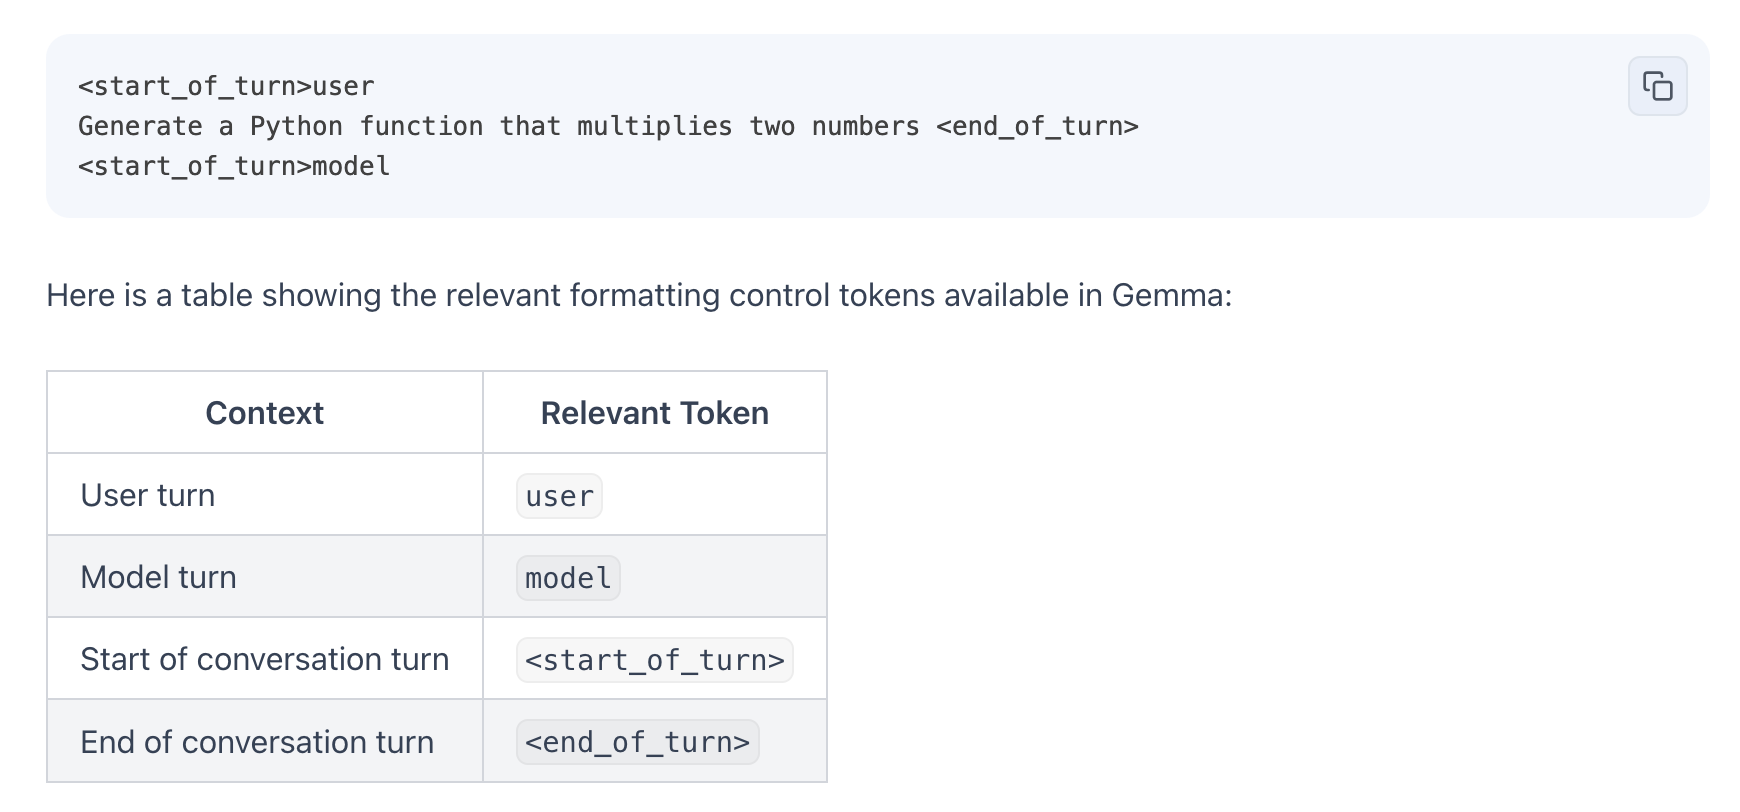

In [33]:
normal_template = """<start_of_turn>user
你是一個很聰明的萬事通，擅長回答各種問題。

問題：{question}<end_of_turn>
<start_of_turn>model
答案："""

normal_prompt = PromptTemplate.from_template(normal_template)

normal_chain = (
    {"question": RunnablePassthrough()}
    | normal_prompt
    | llm
)
normal_chain.invoke("咖啡豆是豆子，那咖啡是豆漿嗎")

'錯誤的。咖啡豆不是豆子，而咖啡則是由咖啡豆製成的。咖啡並非豆漿。'

## Few-shot

In [34]:
fewshot_template = """<start_of_turn>user
你是一個很聰明的萬事通，擅長回答各種問題。

以下為一些例子：
```
問題：學法律的為甚麼叫律師，不叫法師？
答案：因為法師是使用魔法的人

問題：監獄裡都是犯人，為甚麼警察不去裡面抓犯人？
答案：因為他們已經被抓過才進去的
```

現在請回答以下問題
問題：{question}<end_of_turn>
<start_of_turn>model
答案："""

fewshot_prompt = PromptTemplate.from_template(fewshot_template)

fewshot_chain = (
    {"question": RunnablePassthrough()}
    | fewshot_prompt
    | llm
)
fewshot_chain.invoke("咖啡豆是豆子，那咖啡是豆漿嗎")

'錯誤的。咖啡豆不是豆子，而咖啡是從咖啡豆中製成的飲料。'

## Chain of thought(CoT)

In [35]:
CoT_template = """<start_of_turn>user
你是一位數學家，將會幫助回答數學問題。

以下為一些例子：
```
例子1:
問題：當我九歲的時候，我弟弟的年齡是我的三分之二。現在我54歲了，我弟弟幾歲了？
答案：我們一步一步來計算。

當你九歲的時候，你弟弟的年齡是你的三分之二：

你9歲時，你弟弟是 9x(2/3) = 6歲。
現在你54歲了：

你比當時大了45歲（54 - 9 = 45）。
因此，你弟弟現在也比當時大了45歲。
計算你弟弟的年齡：

你弟弟當時6歲，現在他比當時大45歲，所以他現在是6 + 45 = 51歲。
所以，你弟弟現在51歲。


例子2:
問題：當我八歲的時候，我妹妹的年齡是我的四分之一。現在我48歲了，我妹妹幾歲了？
答案：
我們一步一步來計算。

當你八歲的時候，你妹妹的年齡是你的四分之一：

你8歲時，你妹妹是 8*(1/4)=2 歲。
現在你48歲了：

你比當時大了40歲（48 - 8 = 40）。
因此，你妹妹現在也比當時大了40歲。
計算你妹妹的年齡：

你妹妹當時2歲，現在她比當時大40歲，所以她現在是2 + 40 = 42歲。
```

現在請回答以下問題
問題：{question}<end_of_turn>
<start_of_turn>model
答案："""

CoT_prompt = PromptTemplate.from_template(CoT_template)

CoT_chain = (
    {"question": RunnablePassthrough()}
    | CoT_prompt
    | llm
)
CoT_chain.invoke("當我六歲的時候，我妹妹的年齡只有我的一半。 現在我70歲了，我妹妹幾歲了？")

'\n\n我們一步一步來計算。\n\n當你六歲的時候，你妹妹的年齡是你的一半：\n\n你6歲時，你妹妹是 6/2 = 3歲。\n現在你70歲了：\n\n你比當時大了64歲（70 - 6 = 64）。\n因此，你妹妹現在也比當時大了64歲。\n計算你妹妹的年齡：\n\n你妹妹當時3歲，現在她比當時大64歲，所以她現在是3 + 64 = 67歲。\n\n所以，你妹妹現在67歲。'

可以看到用三次答案為 50，兩次為 40，self-consistency 結果為 50。

輸出大部分還是錯的，我們看看 CoT+self-consistency

可以看到 self-consistency 跟 CoT 結合一起使用效果很好，五次都為 67，結果為 67

# 3. 資料集實作 Information Extraction (Tagging)
- https://python.langchain.com/docs/use_cases/tagging/

In [39]:
# 讀入中文示範資料集
origin_data = pd.read_csv('/content/drive/MyDrive/w12_13/Dcard_Travel_Koren.csv')
origin_data.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

clear_df = origin_data.copy()

#去除本次不會用到的欄位
drop_cols = ['boardID', 'commentCount', 'department', 'gender', 'school', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)
# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sampled_df = sent_df.sample(n=100, random_state=222)

sampled_df

,system_id,artUrl,artDate,artTitle,artContent,sentence
4739,159,https://www.dcard.tw/f/travel/p/254417196,2024-01-14 13:24:35,#國外 第一次獨旅大邱釜山Day3,Day 3\n\n第二天晚上友人得知我獨旅來韓國說為何不揪她想來吃醬蟹🦀️我也是超愛醬蟹，當...,剛剛吃了兩小時🤣要離開釜山了～冒著手解凍再來晃晃～
15005,450,https://www.dcard.tw/f/travel/p/255172329,2024-04-04 14:09:01,#國外遊記 #分享 #韓國 交換生的全州兩天一夜小旅行🇰🇷（圖多）,大家安妞👋我是露露～去年在韓國交換了半年，前幾天剪了當時去全州旅行的vlog之後覺得非常懷念...,來了全州怎麼可以不穿韓服呢😍基本上韓屋村裡面到處都是出租韓服的店
15393,463,https://www.dcard.tw/f/travel/p/255064886,2024-03-24 09:49:29,#國外遊記 十天星馬行玩什麼 - 新加坡篇,‼️此篇行程非大眾路線，請小心服用。順序記事，點到點移動都是搭Grab\n\n\nDay 1...,已經大排長龍
2568,68,https://www.dcard.tw/f/travel/p/254467834,2024-01-20 09:16:54,#國外 🇰🇷濟州島自駕自由行（下）,https://www.dcard.tw/f/travel/p/254458511?cid=...,看起來也很有感覺
4933,168,https://www.dcard.tw/f/travel/p/254827687,2024-02-29 10:40:14,#國外遊記 日本東北藏王滑雪🏂、北海道滑雪⛷️私人中文教練課分享（含小叮噹單板、雙板團體課分享）,去年去北海道kiroro滑雪，滑完覺得愛上滑雪XD\n滑完馬上決定今年雪季一定要再去滑雪一次...,教練說初學者能學到C turn就很不錯了我們還能有這些額外的收穫是真的很開心
...,...,...,...,...,...,...
14476,430,https://www.dcard.tw/f/travel/p/254679386,2024-02-15 05:59:21,#國外 #徵旅伴 #韓國 2/16-2/24吃喝玩in大邱首爾釜山,如題，\n2/16-2/18在大邱\n2/18-2/20在首爾\n2/21-2/24在釜山 ...,2/16-2/18在大邱2/18-2/20在首爾2/21-2/24在釜山 很隨性的小型旅程～...
4556,152,https://www.dcard.tw/f/travel/p/254328196,2024-01-04 11:07:41,#其他 #那些年，我們一起約過的旅伴,曾經我覺得，旅行是需要找人一起的。曾經的我也覺得，約出去玩就是單純各顧各的，每個人為自己負責...,旅行是需要找人一起的
3364,101,https://www.dcard.tw/f/travel/p/254576754,2024-02-01 10:23:19,#國外 日本福岡購物超甜大合輯,日本福岡買買日記part2~\n這次去了由布院和福岡，真心喜歡由布院的氛圍，很悠哉泡溫泉很舒...,出水穩定筆尖細(0.1mm)、筆身顏值高、眼線顏色飽滿
10872,329,https://www.dcard.tw/f/travel/p/254717920,2024-02-19 09:12:14,#國外 徵旅伴 不限國家 長期找旅伴🌸,#重發，帳號被bang了 我只好用朋友的再發一次😭\n\n嗨嗨，我是之前一直在歐洲生活的留學...,🔺基本資料：23歲、女生、ENFP快樂小狗外相不尷尬能動能靜能拍照英文溝通沒問題


In [40]:
class KoreaTravel(BaseModel):
    情緒: str = Field(..., description="判斷整個句子總體的情緒。", enum=["正向", "中性", "負向"])
    旅遊景點: str = Field(
        ...,
        description="列出所有句子中提及的韓國旅遊景點並以逗號','分隔。"
    )
    景點種類: str = Field(
        ...,
        description="判斷句子中提到的景點是屬於什麼種類的。",
        enum=["歷史", "自然", "文化", "都市", "娛樂", "購物", "其他", "無"],
    )

travel_parser = JsonOutputParser(pydantic_object=KoreaTravel)

# 透過 get_format_instructions() 可以看到如何告訴 LLM 生成我們想要的格式的一些指令
travel_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"\\u60c5\\u7dd2": {"title": "\\u60c5\\u7dd2", "description": "\\u5224\\u65b7\\u6574\\u500b\\u53e5\\u5b50\\u7e3d\\u9ad4\\u7684\\u60c5\\u7dd2\\u3002", "enum": ["\\u6b63\\u5411", "\\u4e2d\\u6027", "\\u8ca0\\u5411"], "type": "string"}, "\\u65c5\\u904a\\u666f\\u9ede": {"title": "\\u65c5\\u904a\\u666f\\u9ede", "description": "\\u5217\\u51fa\\u6240\\u6709\\u53e5\\u5b50\\u4e2d\\u63d0\\u53ca\\u7684\\u97d3\\u570b\\u65c5\\u904a\\u666f\\u9ede\\u4e26\\u4ee5\\u9017\\u865f\',\'\\u5206\\u9694\\u3002", "type": "string"}, "\\u666f\\u9ede

In [41]:
# Set up a parser + inject instructions into the prompt template.
travel_parser = JsonOutputParser(pydantic_object=KoreaTravel)

travel_template = """<start_of_turn>user
你是一位旅遊評論家，你將會看網路上對於韓國旅遊景點的評論，請抓取出評論中：
1.此評論的情緒，正向或負向或中性
2.有討論到哪些韓國旅遊景點，例如：景福宮、南山塔、弘大
3.景點的種類，例如：歷史、自然、文化

以下為一些範例：
```
範例1
句子：景福宮真是太美了，充滿了歷史的氣息。
抓取結果：{{
“情緒”:“正向”,
“旅遊景點”:“景福宮”,
“景點種類”:“歷史”
}}

範例2
句子：南山塔的夜景真是令人驚嘆。
抓取結果：{{
“情緒”:“正向”,
“旅遊景點”:“南山塔”,
“景點種類”:“都市”
}}

範例3
句子：這次去韓國的旅行真是令人失望。
抓取結果：{{
“情緒”:“負向”,
“旅遊景點”:“無”,
“景點種類”:“無”
}}

範例4
句子：弘大附近有很多好玩的地方和美食。
抓取結果：{{
“情緒”:“正向”,
“旅遊景點”:“弘大”,
“景點種類”:“娛樂”
}}


{format_instructions}
請使用繁體中文回答。
除了 JSON 內容外，不要回答任何其他內容

現在請幫我抓取以下句子的資訊：
句子：{query}
抓取結果：<end_of_turn>
<start_of_turn>model
"""

travel_prompt = PromptTemplate(
    template=travel_template,
    input_variables=["query"],
    partial_variables={"format_instructions": travel_parser.get_format_instructions()},
)

chain = travel_prompt | llm
chain.get_graph().print_ascii()

       +-------------+         
       | PromptInput |         
       +-------------+         
              *                
              *                
              *                
      +----------------+       
      | PromptTemplate |       
      +----------------+       
              *                
              *                
              *                
   +---------------------+     
   | HuggingFaceEndpoint |     
   +---------------------+     
              *                
              *                
              *                
+---------------------------+  
| HuggingFaceEndpointOutput |  
+---------------------------+  


手動建立 parse function

In [42]:
# 從 json 字串中抓取答案
def extract_answer_from_string(string_):
    string_ = string_.replace("\n", "")
    string_ = string_.replace("json", "")
    string_ = string_.replace("    ", "")
    string_ = string_.replace("```", "")
    try:
        # 可以成功轉換
        dict_result = json.loads(string_)
    except:
        print(string_)
        return string_
    return dict_result

# 從 dict 抓取情緒
def get_sentiment(row):
    sentiment = None
    if isinstance(row, dict):
        if ("情緒" in row.keys()):
            sentiment = row['情緒']
    return sentiment

In [43]:
llm_result = extract_answer_from_string(chain.invoke({"query": "景福宮好好吃"}))
print(llm_result)
get_sentiment(llm_result)

{'情緒': '正向', '旅遊景點': '景福宮', '景點種類': '歷史'}


'正向'

In [44]:
sampled_df['LLM'] = sampled_df.apply(lambda x: extract_answer_from_string(chain.invoke({"query": x['sentence']})), axis=1)
sampled_df

該句子並非包含對旅遊景點或情緒的討論，因此無法抓取所需資訊。
無法從所提供之句子中抓取所需資訊，因為該句子並未包含與韓國旅遊景點相關的資訊。
沒有提供句子，因此無法抓取資訊。
此句子並未包含對韓國旅遊景點的評論，因此無法根據要求抓取相關資訊。
The provided sentence is not included in the given context, so I am unable to extract the requested information.
此句子的情緒、旅遊景點和景點種類無法從提供的信息中擷取。因此，我無法提供抓取結果。


,system_id,artUrl,artDate,artTitle,artContent,sentence,LLM
4739,159,https://www.dcard.tw/f/travel/p/254417196,2024-01-14 13:24:35,#國外 第一次獨旅大邱釜山Day3,Day 3\n\n第二天晚上友人得知我獨旅來韓國說為何不揪她想來吃醬蟹🦀️我也是超愛醬蟹，當...,剛剛吃了兩小時🤣要離開釜山了～冒著手解凍再來晃晃～,"{'情緒': '正向', '旅遊景點': '釜山', '景點種類': '文化'}"
15005,450,https://www.dcard.tw/f/travel/p/255172329,2024-04-04 14:09:01,#國外遊記 #分享 #韓國 交換生的全州兩天一夜小旅行🇰🇷（圖多）,大家安妞👋我是露露～去年在韓國交換了半年，前幾天剪了當時去全州旅行的vlog之後覺得非常懷念...,來了全州怎麼可以不穿韓服呢😍基本上韓屋村裡面到處都是出租韓服的店,"{'情緒': '正向', '旅遊景點': '韓屋村', '景點種類': '文化'}"
15393,463,https://www.dcard.tw/f/travel/p/255064886,2024-03-24 09:49:29,#國外遊記 十天星馬行玩什麼 - 新加坡篇,‼️此篇行程非大眾路線，請小心服用。順序記事，點到點移動都是搭Grab\n\n\nDay 1...,已經大排長龍,"{'情緒': '正向', '旅遊景點': '無', '景點種類': '無'}"
2568,68,https://www.dcard.tw/f/travel/p/254467834,2024-01-20 09:16:54,#國外 🇰🇷濟州島自駕自由行（下）,https://www.dcard.tw/f/travel/p/254458511?cid=...,看起來也很有感覺,"{'情緒': '正向', '旅遊景點': '無', '景點種類': '無'}"
4933,168,https://www.dcard.tw/f/travel/p/254827687,2024-02-29 10:40:14,#國外遊記 日本東北藏王滑雪🏂、北海道滑雪⛷️私人中文教練課分享（含小叮噹單板、雙板團體課分享）,去年去北海道kiroro滑雪，滑完覺得愛上滑雪XD\n滑完馬上決定今年雪季一定要再去滑雪一次...,教練說初學者能學到C turn就很不錯了我們還能有這些額外的收穫是真的很開心,"{'情緒': '正向', '旅遊景點': '無', '景點種類': '文化'}"
...,...,...,...,...,...,...,...
14476,430,https://www.dcard.tw/f/travel/p/254679386,2024-02-15 05:59:21,#國外 #徵旅伴 #韓國 2/16-2/24吃喝玩in大邱首爾釜山,如題，\n2/16-2/18在大邱\n2/18-2/20在首爾\n2/21-2/24在釜山 ...,2/16-2/18在大邱2/18-2/20在首爾2/21-2/24在釜山 很隨性的小型旅程～...,"{'情緒': '正向', '旅遊景點': '大邱、首爾、釜山', '景點種類': '城市'}"
4556,152,https://www.dcard.tw/f/travel/p/254328196,2024-01-04 11:07:41,#其他 #那些年，我們一起約過的旅伴,曾經我覺得，旅行是需要找人一起的。曾經的我也覺得，約出去玩就是單純各顧各的，每個人為自己負責...,旅行是需要找人一起的,"{'情緒': '正向', '旅遊景點': '無', '景點種類': '無'}"
3364,101,https://www.dcard.tw/f/travel/p/254576754,2024-02-01 10:23:19,#國外 日本福岡購物超甜大合輯,日本福岡買買日記part2~\n這次去了由布院和福岡，真心喜歡由布院的氛圍，很悠哉泡溫泉很舒...,出水穩定筆尖細(0.1mm)、筆身顏值高、眼線顏色飽滿,"{'情緒': '正向', '旅遊景點': '筆尖', '景點種類': '產品'}"
10872,329,https://www.dcard.tw/f/travel/p/254717920,2024-02-19 09:12:14,#國外 徵旅伴 不限國家 長期找旅伴🌸,#重發，帳號被bang了 我只好用朋友的再發一次😭\n\n嗨嗨，我是之前一直在歐洲生活的留學...,🔺基本資料：23歲、女生、ENFP快樂小狗外相不尷尬能動能靜能拍照英文溝通沒問題,"{'情緒': '正向', '旅遊景點': '無', '景點種類': '個人特徵'}"


In [45]:
sampled_df['sentiment'] = sampled_df.apply(lambda x: get_sentiment(x['LLM']), axis=1)
sampled_df.head()

,system_id,artUrl,artDate,artTitle,artContent,sentence,LLM,sentiment
4739,159,https://www.dcard.tw/f/travel/p/254417196,2024-01-14 13:24:35,#國外 第一次獨旅大邱釜山Day3,Day 3\n\n第二天晚上友人得知我獨旅來韓國說為何不揪她想來吃醬蟹🦀️我也是超愛醬蟹，當...,剛剛吃了兩小時🤣要離開釜山了～冒著手解凍再來晃晃～,"{'情緒': '正向', '旅遊景點': '釜山', '景點種類': '文化'}",正向
15005,450,https://www.dcard.tw/f/travel/p/255172329,2024-04-04 14:09:01,#國外遊記 #分享 #韓國 交換生的全州兩天一夜小旅行🇰🇷（圖多）,大家安妞👋我是露露～去年在韓國交換了半年，前幾天剪了當時去全州旅行的vlog之後覺得非常懷念...,來了全州怎麼可以不穿韓服呢😍基本上韓屋村裡面到處都是出租韓服的店,"{'情緒': '正向', '旅遊景點': '韓屋村', '景點種類': '文化'}",正向
15393,463,https://www.dcard.tw/f/travel/p/255064886,2024-03-24 09:49:29,#國外遊記 十天星馬行玩什麼 - 新加坡篇,‼️此篇行程非大眾路線，請小心服用。順序記事，點到點移動都是搭Grab\n\n\nDay 1...,已經大排長龍,"{'情緒': '正向', '旅遊景點': '無', '景點種類': '無'}",正向
2568,68,https://www.dcard.tw/f/travel/p/254467834,2024-01-20 09:16:54,#國外 🇰🇷濟州島自駕自由行（下）,https://www.dcard.tw/f/travel/p/254458511?cid=...,看起來也很有感覺,"{'情緒': '正向', '旅遊景點': '無', '景點種類': '無'}",正向
4933,168,https://www.dcard.tw/f/travel/p/254827687,2024-02-29 10:40:14,#國外遊記 日本東北藏王滑雪🏂、北海道滑雪⛷️私人中文教練課分享（含小叮噹單板、雙板團體課分享）,去年去北海道kiroro滑雪，滑完覺得愛上滑雪XD\n滑完馬上決定今年雪季一定要再去滑雪一次...,教練說初學者能學到C turn就很不錯了我們還能有這些額外的收穫是真的很開心,"{'情緒': '正向', '旅遊景點': '無', '景點種類': '文化'}",正向


In [46]:
sampled_df['sentiment'].value_counts()

sentiment
正向    73
中性    11
負向     9
Name: count, dtype: int64

In [47]:
# 定義函數來安全地提取字典值
def safe_get(d, key):
    return d.get(key) if isinstance(d, dict) else None

# 將 LLM 字段展開
sampled_df['情緒'] = sampled_df['LLM'].apply(lambda x: safe_get(x, '情緒'))
sampled_df['旅遊景點'] = sampled_df['LLM'].apply(lambda x: safe_get(x, '旅遊景點'))
sampled_df['景點種類'] = sampled_df['LLM'].apply(lambda x: safe_get(x, '景點種類'))

# 計算正向和負向情緒的景點統計
positive_df = sampled_df[sampled_df['sentiment'] == '正向']
negative_df = sampled_df[sampled_df['sentiment'] == '負向']

# 確保旅遊景點是字符串類型
positive_df = positive_df[positive_df['旅遊景點'].apply(lambda x: isinstance(x, str))]
negative_df = negative_df[negative_df['旅遊景點'].apply(lambda x: isinstance(x, str))]

positive_spots = positive_df['旅遊景點']
negative_spots = negative_df['旅遊景點']

positive_counts = positive_spots.value_counts()
negative_counts = negative_spots.value_counts()

In [48]:
negative_df

,system_id,artUrl,artDate,artTitle,artContent,sentence,LLM,sentiment,情緒,旅遊景點,景點種類
6120,195,https://www.dcard.tw/f/travel/p/254815791,2024-02-28 09:57:41,#黑特 韓國首爾滑雪（文長,雙X旅行社，領隊導遊很爛\n\n行程人參、保肝、彩妝，沒達到目標，就關門狂推銷\n\n行程整...,我們從男廁開門出來就有男生在上廁所,"{'情緒': '負向', '旅遊景點': '無', '景點種類': '無'}",負向,負向,無,無
5282,174,https://www.dcard.tw/f/travel/p/254826581,2024-02-29 09:02:22,#國外遊記 首爾6天5夜自由行分享（上集）,剛好在疫情解封之際來到了人生重要的里程碑，我畢業啦🎓，所以就規劃了這一次的首爾6天5夜畢業旅...,麵還沒來我已經吃完一份了,"{'情緒': '負向', '旅遊景點': '無', '景點種類': '無'}",負向,負向,無,無
15173,455,https://www.dcard.tw/f/travel/p/255178507,2024-04-05 09:56:40,#國外遊記 韓國自由行5天4夜下集 #韓式證件照 #維也納咖啡 #花費總整理,下集重點整理\n🗺️景點：韓式證件照、弘大逛街\n☕咖啡廳/甜點：oats coffee、c...,終於走到門口竟然一片漆黑,"{'情緒': '負向', '旅遊景點': '無', '景點種類': '無'}",負向,負向,無,無
11463,354,https://www.dcard.tw/f/travel/p/254728767,2024-02-20 08:38:03,#國外 #首爾#徵旅伴#好相處,{徵韓國旅伴}\n時間：6月\n地點：韓國首爾\n預估費用：機加酒約15000-20000 ...,住宿還沒訂,"{'情緒': '負向', '旅遊景點': '無', '景點種類': '無'}",負向,負向,無,無
6264,195,https://www.dcard.tw/f/travel/p/254815791,2024-02-28 09:57:41,#黑特 韓國首爾滑雪（文長,雙X旅行社，領隊導遊很爛\n\n行程人參、保肝、彩妝，沒達到目標，就關門狂推銷\n\n行程整...,一路上也不會集合指揮,"{'情緒': '負向', '旅遊景點': '無', '景點種類': '無'}",負向,負向,無,無
9296,290,https://www.dcard.tw/f/travel/p/255215311,2024-04-09 10:52:54,#國外遊記 柬埔寨嘎腰之旅 探索三年死了三百萬人的紅色高棉歷史！,大家好！\n\n三天連兩發！（其實是上篇是我觸及最差最沒人想看的一篇，所以發一篇新的）\n\...,可惜,"{'情緒': '負向', '旅遊景點': '無', '景點種類': '無'}",負向,負向,無,無
11052,336,https://www.dcard.tw/f/travel/p/254695285,2024-02-17 01:49:50,#國外 #釜山 走進小王子的世界,\n出發前準備\n韓國入境需要入境卡及健康聲明\n飛機上空姐會發紙本\n健康聲明可以網路填寫...,挑戰辣度二直接原地投降🏳️除了Q彈的魚肉還會有魚內臟但沒有看到安康魚肝,"{'情緒': '負向', '旅遊景點': '無', '景點種類': '無'}",負向,負向,無,無
14628,439,https://www.dcard.tw/f/travel/p/255138378,2024-04-01 02:22:43,#國外遊記 釜山6天五夜自由行～2,第三天的行程是我最～期待的，要去搭膠囊列車。結果….團友b把護照弄丟了🥲所以一大早我跟團友b...,男女進去會分開,"{'情緒': '負向', '旅遊景點': '無', '景點種類': '無'}",負向,負向,無,無


<ipython-input-60-ee0037b80ad9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positive_counts.index, y=positive_counts.values, palette='viridis')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) 

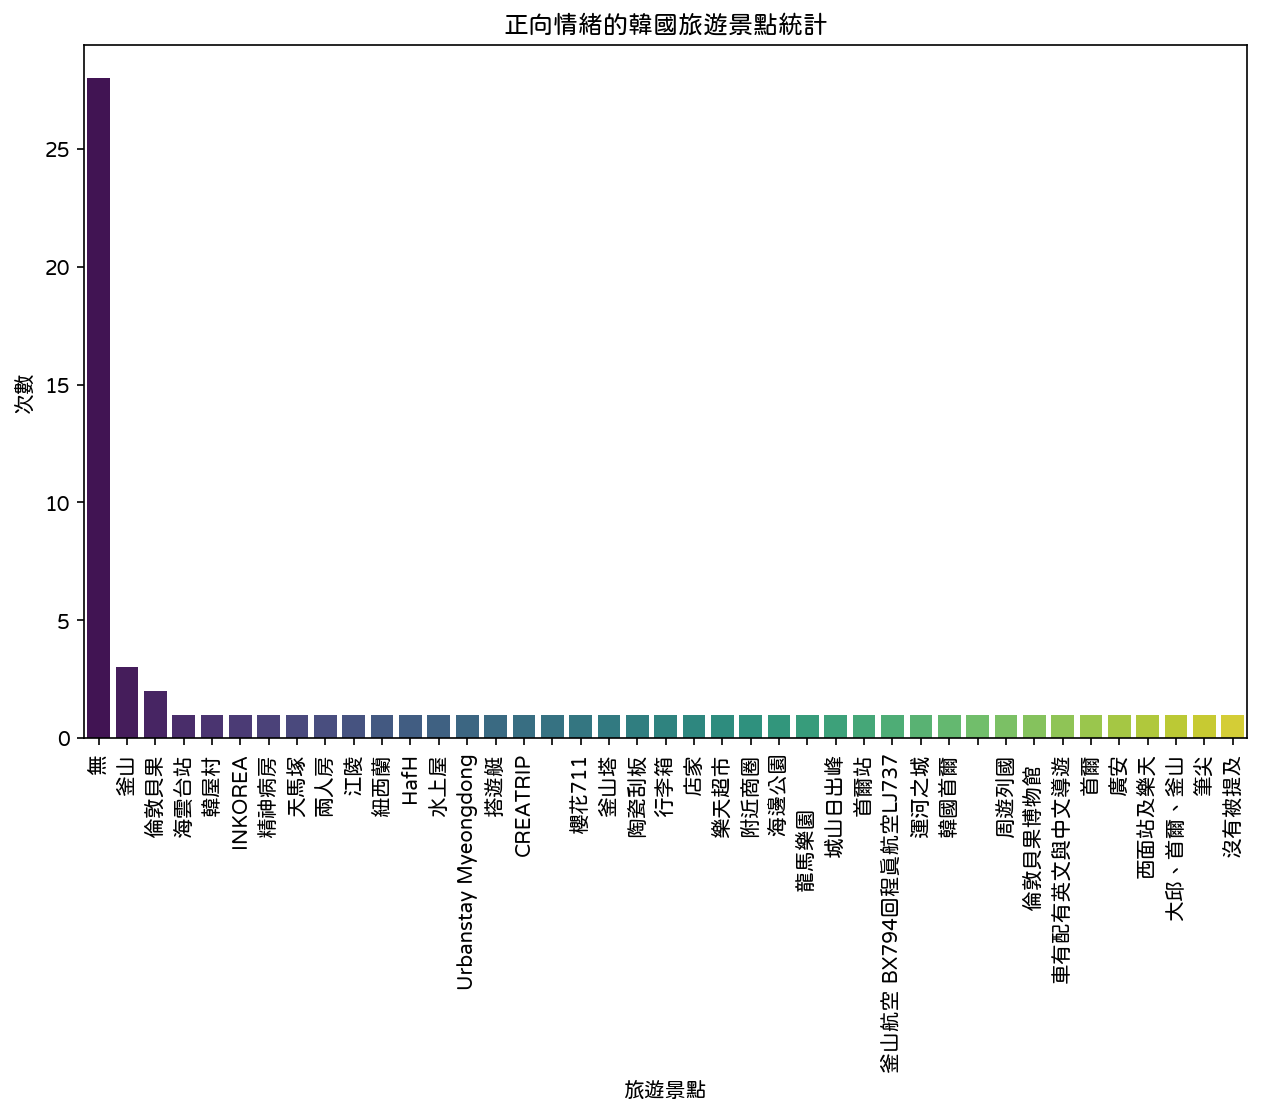

<ipython-input-60-ee0037b80ad9>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=negative_counts.index, y=negative_counts.values, palette='viridis')


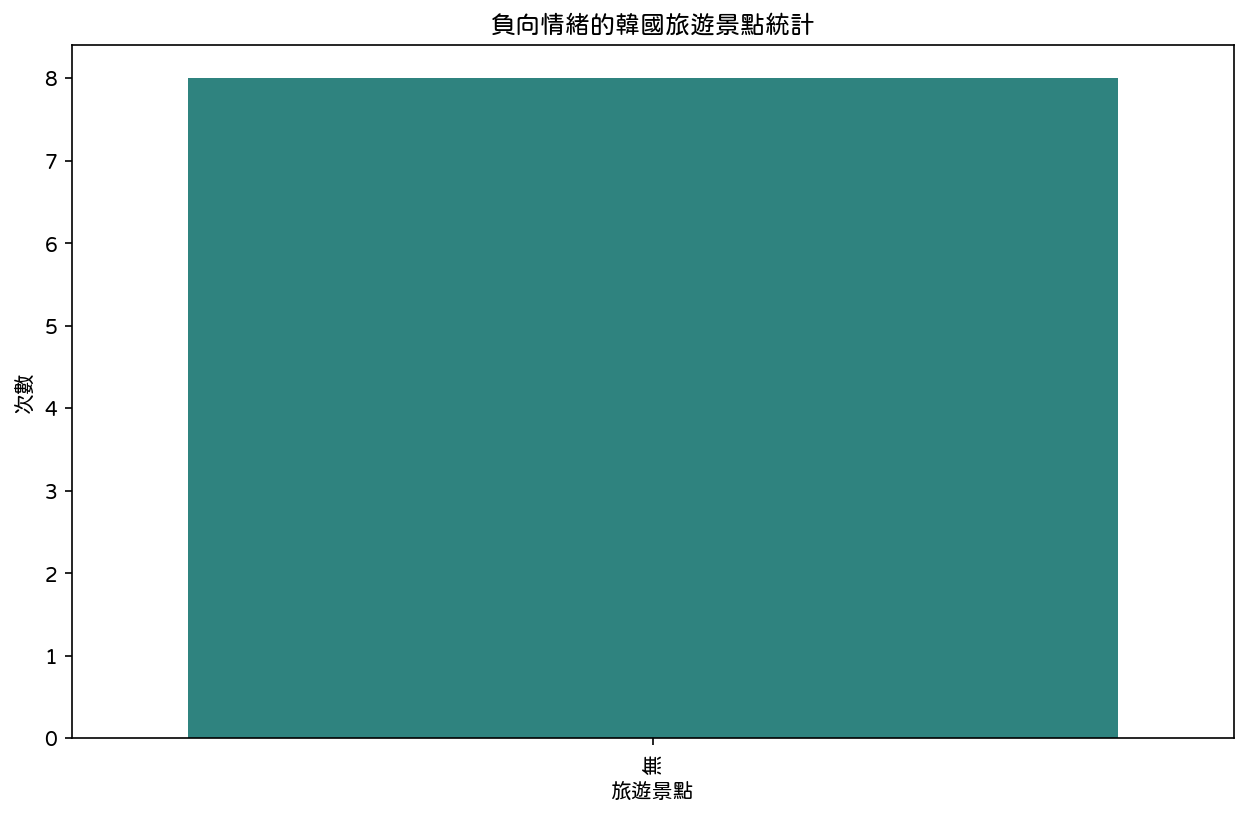

In [60]:
# 繪製正向情緒的景點統計圖
sns.barplot(x=positive_counts.index, y=positive_counts.values, palette='viridis')
plt.title('正向情緒的韓國旅遊景點統計')
plt.xlabel('旅遊景點')
plt.ylabel('次數')
plt.xticks(rotation=90)
plt.show()

# 繪製負向情緒的景點統計圖
sns.barplot(x=negative_counts.index, y=negative_counts.values, palette='viridis')
plt.title('負向情緒的韓國旅遊景點統計')
plt.xlabel('旅遊景點')
plt.ylabel('次數')
plt.xticks(rotation=90)
plt.show()

# 4. Retrieve QA (RAG)

- 官網：https://python.langchain.com/v0.1/docs/use_cases/question_answering/quickstart/
- 讀入 PDF 檔
- 切分檔案 chunk

In [61]:
loader = PyPDFLoader("/content/drive/MyDrive/w12_13/官方版台灣百岳分級.pdf")
pages = loader.load()
pages
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)
texts = text_splitter.split_documents(pages)
texts[:10]

[Document(page_content='官方版台灣百岳分級  - 依路線區分難度  \n官方的「登山分級制度」  \n一般季節分成  4 級 \n A 級：一般健行路線，活動天數約需  1-3 天。  \n B 級：中級縱走路線，活動天數約需  4-5 天或活動天數約需  1-3 天但有危險地形。  \n C 級：高級縱走路線，活動天數約需  5 天以上。  \n C+級：高級縱走路線，有垂降及攀岩地形。  \n雪季期間分成  2 級 \n D 級：雪地健行及縱走，雪季管制期間有條件開放之路線。  \n E 級：雪季管制期間暫停開放之路線。  \nA、B、C 級登山路線  1 人以上即可申請（ 1 人獨攀需填寫獨攀申請承諾書） 。  \nC+級及  D 級登山路線需  3 人以上始可申請； E 級登山路線不開放申請。  \nC+ 級路線需攜帶確保繩及安全頭盔，列為重點檢查項目；  \nD 級路線需相關規定依雪季辦理。  \n概念是： A 級路線不需提供登山經驗證明。  \n申請攀登  B 級路線需有至少  A 級或  B 級以上路線攀登經驗證明，以上類推。  \n所以看來如果沒爬過基本路線是無法第一座百岳就爬奇萊主北；  \n沒走過進階路線想一次跳級大小劍或南二段也是不行的。  \n官方的分級表是用百岳排名排序。依據平常傳統登山習慣，以下依登山路線整理了分級\n表。小原則是如果有山同屬兩條以上路線，則以簡單的那條為準  \n（例如向陽山同為南二段、新康橫斷、嘉明湖經過路線，歸類至最易之嘉明湖） ：', metadata={'source': '/content/drive/MyDrive/w12_13/官方版台灣百岳分級.pdf', 'page': 0}),
 Document(page_content='排名  山名  高度 (m) 位置  分級  路線別  \n約2~3天，入門 A級 \n1 玉山  3952  南投縣信義鄉、高雄縣桃源鄉、嘉義縣吳鳳鄉  A \n玉山前五峰  24 玉山西峰  3528  南投縣信義鄉、嘉義縣吳鳳鄉  A \n65 玉山前峰  3236  南投縣信義鄉、嘉義縣吳鳳鄉  A \n5 雪山  * 3884  苗栗縣泰安鄉、臺中縣和平鄉  A \n雪主東  \n74 雪山東峰  3199  臺中縣和平鄉  A \n16 向陽山

- 將文檔轉換為 embedding
- 存入 vectorDB

In [62]:

embedding_function = SentenceTransformerEmbeddings(model_name="lier007/xiaobu-embedding")

vectorstore = Chroma.from_documents(documents=texts, embedding=embedding_function)

retriever = vectorstore.as_retriever()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

測試找尋相關文檔

In [63]:
# query it
query = "百岳"
docs = vectorstore.similarity_search(query)

# print results
print(docs[0].page_content)

C.北二段：  
★合歡山區：合歡山 3416m、合歡東峰 3416m、北合歡山 3422m、西合歡山 3144m、
石門山 3286m五座百岳，皆可由中橫霧社支線上登   
★奇萊山區：奇萊北山 3605m、奇萊主山 3559m、奇萊南峰 3357m、南華山  3183m、
屏風山 3248m 五座百岳 . 
由松雪樓往成功二、三堡宿，  經一號堡上至 3360山屋，單攻北峰後往主峰，  過卡羅樓
斷崖至卡西或卡東宿，輕裝 攻南華，  至天池，下天池保線所舊址接能高越嶺路，下至蘆
山部落 . 
★太魯閣山列 (奇萊東稜 )：磐石山  3105m、立霧主山 3069m ，太魯閣大山  3282m、帕
托魯山 3100m 四座百岳 . 
東稜為三大箭竹海之一 .自奇萊北往東行，經各山，由 5.4K嵐山工作站水源村出花蓮 .因
嵐山工作鐵道已廢棄，故現今多由研海林道下至中橫 . 
D.北三段 : 
★能高安東軍：  
能高主峰 3261m、能高南峰 3349m、光頭山 3100m、白石山 3108m、安東軍山 3067m 
五座百岳 . 
循能高越嶺路至縣界，離開越嶺路往南沿稜行，飽覽 高山草原風光及大大小小的高山湖
泊，  有『湖泊的故鄉』之稱 . 
★干卓萬山塊：  
干卓萬山 3282m、卓社大山 3343m、火山 3257m、牧山 3239m  四座百岳 . 
其山塊的排列像 J 型，故俗稱 J型縱走 ;由萬大林道至第八林班上干卓萬，三叉峰營地輕
裝攻火山，自卓社大山至武界林道 48K工寮下武界 ;現一般多採由武界林道入山，過栗粟
溪，至 48K工寮及 60K工寮，  採放射性攀登 .


定義 RAG prompt 與 chain

In [66]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_prompt_template = """<start_of_turn>user
"角色": "登山助手",
"服務內容":
你是一個樂於幫助登山愛好者的助手，關於登山活動或相關問題你都可以依照以下文件中的規定來回答。\n
現在給予以下相關文件, 你將會基於以下 [文件][文件] 中的相關文件與 [回答規則][回答規則] 中的回答規則來回答問題。\n
\n
[文件]
{context}
[文件]
\n
[回答規則]
只依據 [文件][文件] 中提供的資訊來回答，並且遵照下列的幾點規則：
- 不撒謊或幻想 [文件][文件] 中未明確提供的答案
- 如果不確定答案或答案未明確包含在 [文件][文件] 中，請回答：“我很抱歉，我不知道如何提供幫助。”
- 回答簡短、相關且簡潔的答案
- 回答字數請少於 150 個字
- 請在 [結果]: 之後回答你的答案
[回答規則]

<</SYS>>
現在，基於上述的文件與規則，回答以下 () 中的問題\n[問題]:({question})\n<end_of_turn>
<start_of_turn>model[結果]:"""

rag_prompt = PromptTemplate.from_template(rag_prompt_template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
)
rag_chain.get_graph().print_ascii()

              +---------------------------------+           
              | Parallel<context,question>Input |           
              +---------------------------------+           
                    ****                ****                
                 ***                        ***             
               **                              ***          
+----------------------+                          **        
| VectorStoreRetriever |                           *        
+----------------------+                           *        
            *                                      *        
            *                                      *        
            *                                      *        
+---------------------+                     +-------------+ 
| Lambda(format_docs) |                     | Passthrough | 
+---------------------+                     +-------------+ 
                    ****                ****                
                        

In [67]:
rag_chain.invoke("B級活動天數為何？")

' B級活動天數約為 4-5 天。'

In [68]:
rag_chain.invoke("百岳有哪些等級")

' 百岳有四個等級：A 級、B 級、C 級和D 級。'